# 配置变量

In [1]:
import numpy as np
import pandas as pd
import os
import torch
from torch import nn
from src.models.NervFormer import NervFormer
from src.learner import Learner, transfer_weights
from src.callback.tracking import *
from src.callback.patch_mask import *
from src.callback.transforms import *
from src.metrics import *
from src.metrics import rmse,mae,REP
from src.basics import set_device,set_seed
from src.datautils import *

import datetime 
import argparse
import joblib
from src.callback.patch_mask import create_patch
from src.power_battery import PowerBatteryData
# from src.explain import explain_funciton
#设计随机种子
class Args:
    def __init__(self, device, is_pretrain, is_finetune, is_linear_probe, explain, 
                 test, predict, project_name, dset_pretrain, dset_finetune, 
                 data_path, batch_size, num_workers, scale, dist, revin, 
                 n_layers, n_layers_dec, prior_dim, n_heads, d_model, dropout, 
                 head_dropout, input_len, output_len, patch_len, stride, 
                 stride_ratio, mask_ratio, recon_weight, kl_temperature, 
                 n_epochs_pretrain, lr, n_epochs_finetune, head_epochs_ratio, 
                 pretrained_model_id, model_type):
        self.device = device
        self.is_pretrain = is_pretrain
        self.is_finetune = is_finetune
        self.is_linear_probe = is_linear_probe
        self.explain = explain
        self.test = test
        self.predict = predict
        self.project_name = project_name
        self.dset_pretrain = dset_pretrain
        self.dset_finetune = dset_finetune
        self.data_path = data_path
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.scale = scale
        self.dist = dist
        self.revin = revin
        self.n_layers = n_layers
        self.n_layers_dec = n_layers_dec
        self.prior_dim = prior_dim
        self.n_heads = n_heads
        self.d_model = d_model
        self.dropout = dropout
        self.head_dropout = head_dropout
        self.input_len = input_len
        self.output_len = output_len
        self.patch_len = patch_len
        self.stride = stride
        self.stride_ratio = stride_ratio
        self.mask_ratio = mask_ratio
        self.recon_weight = recon_weight
        self.kl_temperature = kl_temperature
        self.n_epochs_pretrain = n_epochs_pretrain
        self.lr = lr
        self.n_epochs_finetune = n_epochs_finetune
        self.head_epochs_ratio = head_epochs_ratio
        self.pretrained_model_id = pretrained_model_id
        self.model_type = model_type
        # ... 其他参数

args = Args(
    device=3, is_pretrain=0, is_finetune=0, is_linear_probe=1, explain=0, 
    test=True, predict=True, project_name='power_battery', dset_pretrain='Power-Battery', 
    dset_finetune='Power-Battery', data_path='./data/local_data_structure', batch_size=512, 
    num_workers=0, scale=True, dist=False, revin=0, n_layers=4, n_layers_dec=2, 
    prior_dim=6, n_heads=16, d_model=512, dropout=0.15, head_dropout=0.05, 
    input_len=96, output_len=192, patch_len=1000, stride=True, stride_ratio=1.0, 
    mask_ratio=0.4, recon_weight=0.5, kl_temperature=0.1, n_epochs_pretrain=300, 
    lr=1e-4, n_epochs_finetune=200, head_epochs_ratio=0.05, pretrained_model_id=1, 
    model_type='based_model'
    # ... 其他参数
)

args.finetuned_model_id = 1

args.stride = int(args.patch_len * args.stride_ratio)
args.dist = False
print('args:', args)
args.pretrained_model = 'patchtst_pretrained_dataset'+str(args.dset_pretrain)+'_patch'+str(args.patch_len) + '_stride'+str(args.stride) + '_epochs-pretrain' + str(args.n_epochs_pretrain) + '_mask' + str(args.mask_ratio)  + '_model' + str(args.pretrained_model_id)
args.save_path = 'saved_models/' + args.dset_pretrain + '/masked_patchtst/' + args.model_type + '/'
if not os.path.exists(args.save_path): os.makedirs(args.save_path)

time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
# args.save_finetuned_model = '_cw'+str(args.context_points)+'_tw'+str(args.output_len) + '_patch'+str(args.patch_len) + '_stride'+str(args.stride) + '_epochs-finetune' + str(args.n_epochs_finetune) + '_mask' + str(args.mask_ratio)  + '_model' + str(args.finetuned_model_id)
suffix_name = '_time'+str(time)+'_ol'+str(args.output_len) + '_patch'+str(args.patch_len) + '_stride'+str(args.stride) + '_epochs-finetune' + str(args.n_epochs_finetune) + '_model' + str(args.finetuned_model_id)+ '_n_layer'+str(args.n_layers)+'_n_dec'+str(args.n_layers_dec)+'_n_head'+str(args.n_heads)+'_d_model'+str(args.d_model)+'_dropout'+str(args.dropout)+'_head_dropout'+str(args.head_dropout)
args.d_ff = 4 * args.d_model
args.save_pretrained_model = args.pretrained_model
args.save_linear_probe_model = 'linear_probe' + suffix_name
args.save_finetuned_model = 'finetuned' + suffix_name
# get available GPU devide
if not args.dist:
    set_device(device_id=args.device)
set_seed(3407)

args: <__main__.Args object at 0x7f2b7a8ddac0>


In [2]:
def get_model(c_in, head_type,args):
    """
    c_in: number of variables
    """
    # get number of patches
    
    # get modelxb, yb
    model = NervFormer(c_in=c_in,head_type=head_type,
                target_dim=args.output_len,
                patch_len=args.patch_len,
                stride=args.stride,
                n_layers=args.n_layers,
                n_layers_dec=args.n_layers_dec,
                n_heads=args.n_heads,
                d_model=args.d_model,
                shared_embedding=True,
                d_ff=args.d_ff,                        
                dropout=args.dropout,
                head_dropout=args.head_dropout,
                act='relu',
                res_attention=False,
                prior_dim=args.prior_dim,
                input_len=args.input_len,
                output_len=args.output_len,
                )        
    # print out the model size
    print('number of model params', sum(p.numel() for p in model.parameters() if p.requires_grad))
    return model


## 导入数据

In [3]:
def get_dataset_dict(args):
    dataset_dict = {}
    if args.task_flag =='pretrain':
        dataset_dict['pretrain'] = PowerBatteryData(**{
                'data_path': args.data_path,
                'scale': args.scale,
                'size':[args.input_len,args.output_len],
                }, split='pretrain')
    if args.task_flag == 'finetune' or args.task_flag == 'linear_probe':
        "make dataset: {}\n".format(args.task_flag)
        dataset_dict['train'] = PowerBatteryData(**{
                'data_path': args.data_path,
                'scale': args.scale,
                'size':[args.input_len,args.output_len],
                }, split='train')
        dataset_dict['val'] =  PowerBatteryData(**{
                'data_path': args.data_path,
                'scale': args.scale,
                'size':[args.input_len,args.output_len],
                }, split='val')
        dataset_dict['test'] =  PowerBatteryData(**{
                'data_path': args.data_path,
                'scale': args.scale,
                'size':[args.input_len,args.output_len],
                }, split='test')
    if args.task_flag == 'test':
        dataset_dict['test'] = PowerBatteryData(**{
                'data_path': args.data_path,
                'scale': args.scale,
                'size':[args.input_len,args.output_len],
                }, split='test')
    return dataset_dict

input_len = args.input_len
finetune_strie_ratio = args.stride_ratio
args.dset = args.dset_pretrain
args.initialize_wandb = False
args.task_flag = 'pretrain'
args.batch_size = 1



# 导入模型

In [4]:
args.head_type = 'prior_pooler'
model = get_model(19, args.head_type,args)
#根据device_id选择设备
model = transfer_weights('saved_models/Power-Battery/masked_patchtst/based_model/linear_probe_time2024-02-23-04-03-33_ol192_patch1000_stride1000_epochs-finetune200_model1_n_layer4_n_dec2_n_head16_d_model512_dropout0.15_head_dropout0.05.pth',model)
print('load linear_probe model')

number of model params 52774281
weights from saved_models/Power-Battery/masked_patchtst/based_model/linear_probe_time2024-02-23-04-03-33_ol192_patch1000_stride1000_epochs-finetune200_model1_n_layer4_n_dec2_n_head16_d_model512_dropout0.15_head_dropout0.05.pth successfully transferred!

load linear_probe model


# 使用Conformal 预测

## 构建数据集

In [5]:
args.task_flag = 'linear_probe'
dataset_dict = get_dataset_dict(args)
dls = get_dls(args,dataset_dict)


读取CL21成功
读取CL02成功
读取CL22成功
读取CL24成功
读取CL25成功
读取CL13成功
读取CL11成功
读取CL12成功
读取CL07成功
读取CL04成功
读取CL15成功
读取CL01成功
读取CL08成功
读取CL05成功
读取CL27成功
读取CL10成功
读取CL09成功
读取CL14成功
读取CL26成功
读取CL20成功
读取CL03成功
读取CL06成功
读取scaler成功
车辆CL21的有效充电循环数为233
车辆CL02的有效充电循环数为505
车辆CL22的有效充电循环数为158
车辆CL24的有效充电循环数为233
车辆CL25的有效充电循环数为218
车辆CL13的有效充电循环数为210
车辆CL11的有效充电循环数为241
车辆CL12的有效充电循环数为327
车辆CL07的有效充电循环数为444
车辆CL04的有效充电循环数为442
车辆CL15的有效充电循环数为339
车辆CL01的有效充电循环数为87
车辆CL08的有效充电循环数为221
车辆CL05的有效充电循环数为386
车辆CL27的有效充电循环数为147
车辆CL10的有效充电循环数为335
车辆CL09的有效充电循环数为380
车辆CL14的有效充电循环数为260
读取CL21成功
读取CL02成功
读取CL22成功
读取CL24成功
读取CL25成功
读取CL13成功
读取CL11成功
读取CL12成功
读取CL07成功
读取CL04成功
读取CL15成功
读取CL01成功
读取CL08成功
读取CL05成功
读取CL27成功
读取CL10成功
读取CL09成功
读取CL14成功
读取CL26成功
读取CL20成功
读取CL03成功
读取CL06成功
读取scaler成功
车辆CL26的有效充电循环数为172
车辆CL20的有效充电循环数为256
车辆CL03的有效充电循环数为462
车辆CL06的有效充电循环数为481
读取CL21成功
读取CL02成功
读取CL22成功
读取CL24成功
读取CL25成功
读取CL13成功
读取CL11成功
读取CL12成功
读取CL07成功
读取CL04成功
读取CL15成功
读取CL01成功
读取CL08成功
读取CL05成功
读取CL27成功
读取CL10成功
读取CL09成功
读取CL14成功
读取C

## 模型推理

In [6]:
cbs = [PatchCB(patch_len=args.patch_len, stride=args.stride)]
learn = Learner(dls, model,cbs=cbs,flag=args.task_flag,args=args)
score = [rmse,mae,REP]
model.to('cuda')
out_train  = learn.test(dls.train,model, scores=score) 
out_test = learn.test(dls.test,model, scores=score)
scaler = joblib.load('./data/target_scaler.pkl')
pred_train = scaler.inverse_transform(out_train[0])
true_train = scaler.inverse_transform(out_train[1])
pred_test = scaler.inverse_transform(out_test[0])
true_test = scaler.inverse_transform(out_test[1])

##　合式预测计算区间

In [10]:
##读取npy文件
pred_test = np.load('result/192/2024-02-23-04-46-53out_len192_pred.npy')
true_test = np.load('result/192/2024-02-23-04-46-53out_len192_true.npy')

In [11]:
# 计算合式预测的置信区间阈值
alpha = 0.05 # 95%置信水平
# 定义上界非异性度量（预测过高的情况）

error_abs = np.abs(pred_train - true_train)
# 确定上界和下界的阈值
quantile_lower = np.quantile(error_abs, 1 - alpha,axis=0)



In [17]:
input_len = 96

input.shape 

(96,)

ValueError: x and y must have same first dimension, but have shapes (96,) and (192,)

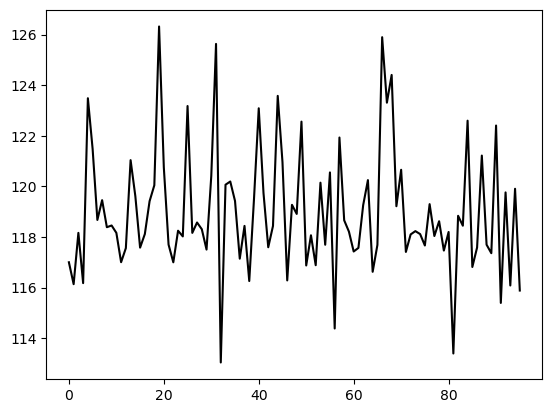

In [21]:
import matplotlib.pyplot as plt
input_len = 96
# 计算每行的误差
error_test = np.abs(pred_test - true_test)

# 计算每行的最大误差
max_error = np.mean(error_test, axis=1)

# 找到最大误差最小的行索引
min_max_error_row_index = np.argmin(max_error)

# 获取最大误差最小的一行数组
min_error_row_pred = pred_test[min_max_error_row_index]
min_error_row_true = true_test[min_max_error_row_index]
input = true_test[min_max_error_row_index-input_len][:input_len]# 创建一个新的图形
plt.figure()
# plt.plot(range(input_len),input, 'black', label='Past values')
# 绘制区间预测
plt.plot(range(len(min_error_row_true)),min_error_row_pred, 'b-', label='Predicted mean')
# 绘制实际观测值
plt.plot( range(len(min_error_row_true)),min_error_row_true, 'r-', label='True values')
plt.fill_between(range(len(min_error_row_true)),min_error_row_pred- quantile_lower, min_error_row_pred+quantile_lower, color='gray', alpha=0.5, label='Predicted interval')
 
# 添加图例
plt.legend()

# 显示图形
plt.show()

In [9]:
min_max_error_row_index

225